#### ▶ **Candidate Numbers: 15, 18, 17, 33, 42**

# **Jupyter Notebook 3: Impact of Data Augmentation**

---





To evaluate the impact of augmentation techniques on model performance, we applied the following techniques:

*   RandomRotation
*   ColorJitter
*   RandomAffine

---





🌿  We decided that the Jupyter notebook will contain a total of 6 sections, each dedicated to a separate experiment for easier navigation, as outlined below:


| Total number of Notebook: 6                         | Content                                                                                   |
|------------------------------------|-------------------------------------------------------------------------------------------|
|Jupyter Notebook 1: Master U-Net Workflow              | Data preparation, U-Net implementation, training, and evaluation                           |
|Jupyter Notebook 2: Impact of Image Resolution**      | **Experiment with 3 different image resolutions and track performance (64x64, 128x128 and 256x256)                          |
|**Jupyter Notebook 3: Impact of Data Augmentation**     | **Experiment with data augmentation techniques (3 augmentation with vs. without augmentation)**               |
|Jupyter Notebook 4: Impact of Training Data Size    | Experiment with 3 different training data sizes (20%, 50% and 100%)                      |
|Jupyter Notebook 5: Impact of Optimizer             | Experiment with 3 different optimizers (Adam, SGD, RMSprop)                                  |
|Jupyter Notebook 6: Impact of Activation Function   | Experiment with 3 different activation functions (ReLU, Leaky Tanh with Sigmoid)           |


# **Install Required Libaries:**

---



In [ ]:
!pip install torch torchvision
!pip install torchsummary
!pip install wandb

In [ ]:
import os
from PIL import Image
import albumentations as A
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import tarfile
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import random
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from albumentations.pytorch import ToTensorV2
import torch
import wandb
from torch.utils.data import Dataset
from albumentations import Compose
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.optim.lr_scheduler as lr_scheduler

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


#🍀 **Wandb Installation**

---



In [ ]:
!pip install wandb
!wandb login
import wandb

!wandb enabled

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
W&B enabled.


# **Check if CUDA device exists, use that. If not default to CPU:**

---



In [ ]:
# If CUDA device exist, use that. If not default to CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0




---


# 🍀 **Data Pipeline**


---





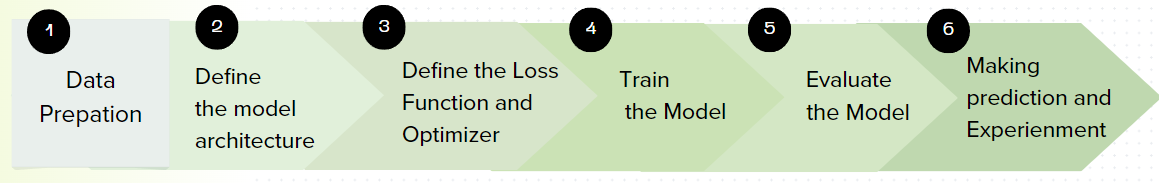



---

# **1. Prepare the Dataset:**

---



## **1.1) Extract images and masks tar.gz files :**




In [ ]:
with tarfile.open('/content/images.tar.gz', 'r:gz') as tar:
    tar.extractall('/content/images')
with tarfile.open('/content/masks.tar.gz', 'r:gz') as tar:
    tar.extractall('/content/masks')


▶ **Get the list of files in each directory and print their counts**

In [ ]:
images_dir = '/content/images/images'
masks_dir = '/content/masks/masks'

images_list = os.listdir(images_dir)
masks_list = os.listdir(masks_dir)

print(f"Number of images: {len(images_list)}")
print(f"Number of masks: {len(masks_list)}")
print(f".............................")
print(f"Images directories contents: {images_list[:10]}")
print(f"Masks directories contents: {masks_list[:10]}")

Number of images: 590
Number of masks: 590
.............................
Images directories contents: ['ckcudjprd000u3b5y0inb980n.jpg', 'ckcx96ts600103b5y1t1feqnv.jpg', 'ckcx44haz000m3b5ycpibb6ac.jpg', 'ckcudav17000j3b5ynmszygwj.jpg', 'ckd09bezs000c3b5yy33w0pw6.jpg', 'ckcvwgykr00123b5ynu32bppx.jpg', 'ckd4ka6fx000a3b5y5l4rc1b0.jpg', 'ckd01b91d000o3b5yk4p8hydx.jpg', 'ckcuhse7w001o3b5y3cucoi29.jpg', 'ckcua1vxx000s3b5yqqwohpza.jpg']
Masks directories contents: ['ckczzh7yq00063b5ybca6safc.png', 'ckcu9r72l000e3b5yerhwmjut.png', 'ckd49a4rr000e3b5ywtkc4n3s.png', 'ckcvw89rb000p3b5ycvszaz7y.png', 'ckd4jmdk7001e3b5yj8s1c8nb.png', 'ckcuhxfpt001t3b5yco20hyda.png', 'ckcxcvti6000n3b5y52wjx18l.png', 'ckcxcm3p800083b5yio6him4i.png', 'ckd04otrd000d3b5yffhdvb9k.png', 'ckd4goa09000g3b5ym2g6nixv.png']


▶ **Check if image and mask are in the binary range (0,1)**

In [ ]:
images_out_of_range_count = 0
masks_out_of_range_count = 0

# Check if all images are between 0 and 1
for i in images_list:
    image_path = os.path.join(images_dir, i)
    image = np.array(Image.open(image_path).convert("RGB")) / 255.0  # Normalize image to [0,1]

    if not np.all((image >= 0) & (image <= 1)):
        images_out_of_range_count += 1

# Check if all masks are binary (0,1)
for i in masks_list:
    mask_path = os.path.join(masks_dir, i)
    mask = np.array(Image.open(mask_path))

    if not np.all((mask == 0) | (mask == 1)):
        masks_out_of_range_count += 1

# Summary
if images_out_of_range_count == 0:
    print("All training images are within the range [0, 1].")
else:
    print(f"{images_out_of_range_count} training images have values outside the range [0, 1].")

if masks_out_of_range_count == 0:
    print("All training masks are binary (0 or 1).")
else:
    print(f"{masks_out_of_range_count} training masks have values outside the binary range [0, 1].")

All training images are within the range [0, 1].
590 training masks have values outside the binary range [0, 1].


▶ **Plot to see the distribution of both image and mask**

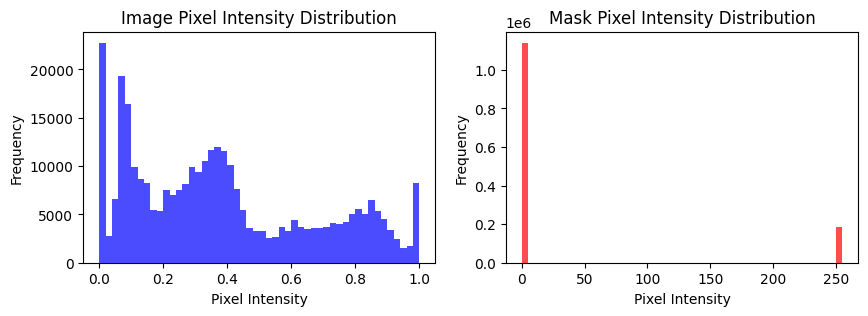

In [ ]:
import matplotlib.pyplot as plt

def plot_histogram(image_name, mask_name):
    image_path = os.path.join(images_dir, image_name)
    mask_path = os.path.join(masks_dir, mask_name)

    # Load image and mask
    image = np.array(Image.open(image_path).convert("L")) / 255.0
    mask = np.array(Image.open(mask_path))
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))

    # Image histogram
    axes[0].hist(image.ravel(), bins=50, color='blue', alpha=0.7)
    axes[0].set_title("Image Pixel Intensity Distribution")
    axes[0].set_xlabel("Pixel Intensity")
    axes[0].set_ylabel("Frequency")

    # Mask histogram
    axes[1].hist(mask.ravel(), bins=50, color='red', alpha=0.7)
    axes[1].set_title("Mask Pixel Intensity Distribution")
    axes[1].set_xlabel("Pixel Intensity")
    axes[1].set_ylabel("Frequency")
    plt.show()

plot_histogram(images_list[0], masks_list[0])

▶ **Find matchine images mask pairs**



In [ ]:
images_dir = '/content/images/images'
masks_dir = '/content/masks/masks'

image_files = {os.path.splitext(f)[0] for f in os.listdir(images_dir) if f.endswith('.jpg')}
mask_files = {os.path.splitext(f)[0] for f in os.listdir(masks_dir) if f.endswith('.png')}

# Find common files
common_files = list(image_files.intersection(mask_files))
print(f"Total match images and masks pairs: {len(common_files)}")

Total match images and masks pairs: 590


▶ **List out sample of images and masks**



Loading image: /content/images/images/ckd4iebll00033b5yts7hmhlg.jpg
Loading image: /content/images/images/ckcxcr149000f3b5y6wr9rg7c.jpg
Loading image: /content/images/images/ckd4h7fq300153b5yhdzs5yar.jpg
Loading image: /content/images/images/ckd03cgbx00133b5yaywin2kz.jpg
Loading image: /content/images/images/ckcx9nmko001u3b5yopeccdvo.jpg
Loading mask: /content/masks/masks/ckd4iebll00033b5yts7hmhlg.png
Loading mask: /content/masks/masks/ckcxcr149000f3b5y6wr9rg7c.png
Loading mask: /content/masks/masks/ckd4h7fq300153b5yhdzs5yar.png
Loading mask: /content/masks/masks/ckd03cgbx00133b5yaywin2kz.png
Loading mask: /content/masks/masks/ckcx9nmko001u3b5yopeccdvo.png


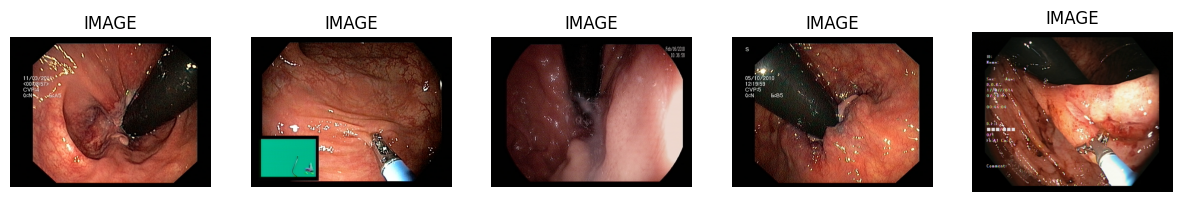

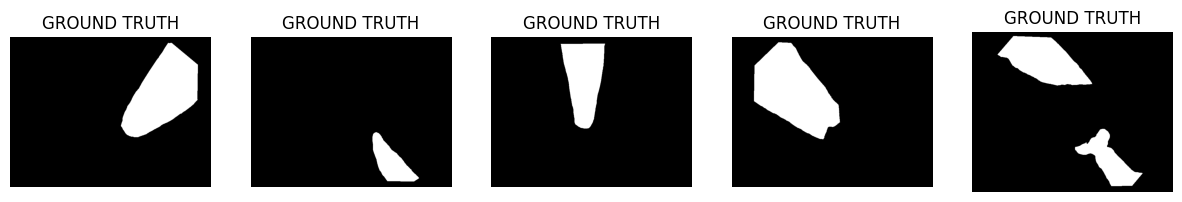

In [ ]:
# Load file names and create a DataFrame with absolute paths
image_files = sorted([os.path.join(images_dir, f) for f in os.listdir(images_dir)])
mask_files = sorted([os.path.join(masks_dir, f) for f in os.listdir(masks_dir)])
df = pd.DataFrame({'Image File': image_files, 'Mask File': mask_files})
sample = df.sample(n=5, random_state=42)

# Define functions to display images and masks
def generate_sample_images(sample):
    imgs = sample['Image File']

    _, ax = plt.subplots(1, 5, figsize=(15, 3))
    ax = ax.flatten()

    for i, image_path in enumerate(imgs):
        print(f"Loading image: {image_path}")

        image = cv2.imread(image_path)
        if image is None:
            print(f"Warning: Could not load image at path {image_path}")
            ax[i].set_title("IMAGE NOT FOUND")
            ax[i].imshow(np.zeros((64, 64, 3), dtype=np.uint8))
            ax[i].axis('off')
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax[i].imshow(image)
        ax[i].set_title("IMAGE")
        ax[i].axis('off')

def generate_sample_masks(sample):
    masks = sample['Mask File']

    _, ax = plt.subplots(1, 5, figsize=(15, 3))
    ax = ax.flatten()

    for i, mask_path in enumerate(masks):
        print(f"Loading mask: {mask_path}")

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"Warning: Could not load mask at path {mask_path}")
            ax[i].set_title("MASK NOT FOUND")
            ax[i].imshow(np.zeros((64, 64), dtype=np.uint8), cmap='gray')
            ax[i].axis('off')
            continue

        ax[i].imshow(mask, cmap='gray')
        ax[i].set_title("GROUND TRUTH")
        ax[i].axis('off')

# Generate and display sample images and masks
generate_sample_images(sample)
generate_sample_masks(sample)


## **1.2) Load train and test file lists :**

---



In [ ]:
with open('/content/train.txt', 'r') as f:
    train_files = f.read().splitlines()
with open('/content/test.txt', 'r') as f:
    test_files = f.read().splitlines()

print(f"Number of training files: {len(train_files)}")
print(f"Number of testing files: {len(test_files)}")
print(f"...........................................")
print(f"Example of testing files: {train_files[:5]}")
print(f"Example of testing files: {test_files[:5]}")

Number of training files: 472
Number of testing files: 118
...........................................
Example of testing files: ['ckcvw5yhd000m3b5yutirmiad', 'ckcvwpanj001b3b5ysxixpcxy', 'ckcuhbkeo000z3b5yq7v1sm0o', 'ckd0afl7u000a3b5y3crqjxla', 'ckcxb6cne000x3b5ynaznq58f']
Example of testing files: ['ckd4ipizn000d3b5yk2vrbyyz', 'ckcxct8oj000k3b5y9iwia72h', 'ckd4ig3d700043b5y0p70afjj', 'ckd03in4g001d3b5yngyc734r', 'ckcx9nmko001u3b5yopeccdvo']


## **1.3) Define image and mask transformations / Custom dataset / set up Data loader :**

---



In [ ]:
albumentations_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

class KvasirDataset(Dataset):
    def __init__(self, file_list, img_dir, mask_dir, albumentations_transform=None):
        self.file_list = file_list
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.albumentations_transform = albumentations_transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = self.file_list[idx]
        img_path = os.path.join(self.img_dir, img_name + '.jpg')
        mask_path = os.path.join(self.mask_dir, img_name + '.png')

        # Load the image and mask
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # DELETE THIS LINE
        mask = mask/255.0

        if image is None or mask is None:
            raise ValueError(f"Error loading image or mask for {img_name}")

        # Apply Albumentations transformations
        if self.albumentations_transform:
            augmented = self.albumentations_transform(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']

         # DELETE THIS LINE
        mask = mask.unsqueeze(0).float() # Add channel dimension and convert to Float


        return image, mask
from torch.utils.data import DataLoader

# Example file list, replace with actual train/test files

with open('/content/train.txt', 'r') as f:
    train_files = [os.path.splitext(line.strip())[0] for line in f.readlines()]  # Remove extension
with open('/content/test.txt', 'r') as f:
    test_files = [os.path.splitext(line.strip())[0] for line in f.readlines()]  # Remove extension


# Initialize datasets
train_dataset = KvasirDataset(train_files, images_dir, masks_dir, albumentations_transform=albumentations_transform)
test_dataset = KvasirDataset(test_files, images_dir, masks_dir, albumentations_transform=albumentations_transform)

# Create DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4, drop_last=False)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


▶ **Verify by printing a sample bath size**

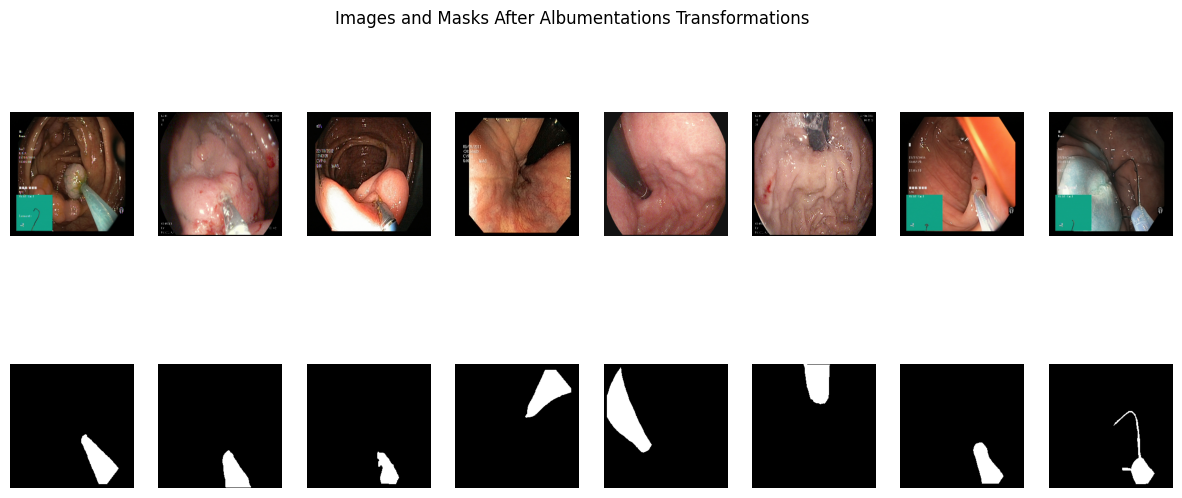

In [ ]:
import matplotlib.pyplot as plt
import torchvision

def visualize_batch(loader):
    # Get a batch of images and masks
    images, masks = next(iter(loader))

    # Create a figure to display images and masks
    fig, axes = plt.subplots(2, min(8, len(images)), figsize=(15, 6))
    fig.suptitle("Images and Masks After Albumentations Transformations")

    for i in range(min(8, len(images))):
        # Display the image
        image = images[i].permute(1, 2, 0).cpu().numpy()  # Convert to (H, W, C) for display
        image = (image * 0.5 + 0.5)  # Reverse normalization to [0,1] range
        axes[0, i].imshow(image)
        axes[0, i].axis("off")
        # axes[0, i].set_title("Transformed Image")

        # Display the mask
        mask = masks[i].cpu().numpy().squeeze()  # Remove channel dimension if present
        axes[1, i].imshow(mask, cmap="gray")
        axes[1, i].axis("off")
        # axes[1, i].set_title("Transformed Mask")

    plt.show()

# Call the function to visualize a batch from train_loader
visualize_batch(train_loader)


In [ ]:
# Fetch a random batch from the DataLoader
for images, masks in train_loader:

    # before transformation
    print(f"Resized image size (before transformation): {images.shape}")
    print(f"Resized mask size (before transformation): {masks.shape}")

    # after transformation
    print(f"Image size after transformation: {images.size()}")
    print(f"Mask size after transformation: {masks.size()}")

    break
print('................................................................................')
images, masks = next(iter(train_loader))
print(f"Train batch - Images: {images.shape}, Masks: {masks.shape}")  #  gives the size of each dimension in a tuple form - 8: Batch size (likely 8 images processed at once) - 3: Number of channels (for RGB images - 256x256: Image resolution.
imafes, masks = next(iter(test_loader))
print(f"Train batch = Images: {images.shape}, Masks: {masks.shape}")
print('.................................................................................')
print(f"Image dimension: {np.array(images).ndim}") # the number of dimensions - batch size, channels, height, and widt
print(f"Maak dimension: {np.array(masks).ndim}")

Resized image size (before transformation): torch.Size([8, 3, 256, 256])
Resized mask size (before transformation): torch.Size([8, 1, 256, 256])
Image size after transformation: torch.Size([8, 3, 256, 256])
Mask size after transformation: torch.Size([8, 1, 256, 256])
................................................................................
Train batch - Images: torch.Size([8, 3, 256, 256]), Masks: torch.Size([8, 1, 256, 256])
Train batch = Images: torch.Size([8, 3, 256, 256]), Masks: torch.Size([8, 1, 256, 256])
.................................................................................
Image dimension: 4
Maak dimension: 4


▶ **Check if masks in the DataLoader are binary**

In [ ]:
# Check if masks in the DataLoader are binary
for images, masks in train_loader:
    unique_values = torch.unique(masks)
    print("Unique values in a batch of masks:", unique_values)
    if not torch.all((unique_values == 0) | (unique_values == 1)):
        print("Warning: Mask contains values other than 0 and 1.")
    else:
        print("Masks are binary.")
    break  # Check only the first batch


Unique values in a batch of masks: tensor([0., 1.])
Masks are binary.


In [ ]:
print(f"Number of training images: {len(train_loader.dataset)}")
print(f"Number of testing images: {len(test_loader.dataset)}")
print(f"Number of training batches: {len(train_loader)}")  # Should be len(train_loader.dataset) / batch_size
print(f"Number of testing batches: {len(test_loader)}")  # Should be len(test_loader.dataset) / batch_size


Number of training images: 472
Number of testing images: 118
Number of training batches: 59
Number of testing batches: 15




---


# **2. Define the model architecture**


---



In [ ]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder part (contracting path)
        self.enc1 = self.conv_block(3, 64, p=0.3)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = self.conv_block(64, 128, p=0.3)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = self.conv_block(128, 256, p=0.3)
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = self.conv_block(256, 512, p=0.3)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck (bottom of the U)
        self.bottleneck = self.conv_block(512, 1024, p=0.3)

        # Decoder part (expanding path)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self.conv_block(1024, 512, p=0.3)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(512, 256, p=0.3)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128, p=0.3)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64, p=0.3)

        # Final output layer
        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels, p=0.3):
        """Convolutional block with dropout."""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(), # Relu activation function
            nn.Dropout(p)
        )

    def forward(self, x):
        # Encoder
        x1 = self.enc1(x)
        p1 = self.pool1(x1)

        x2 = self.enc2(p1)
        p2 = self.pool2(x2)

        x3 = self.enc3(p2)
        p3 = self.pool3(x3)

        x4 = self.enc4(p3)
        p4 = self.pool4(x4)

        # Bottleneck
        b = self.bottleneck(p4)

        # Decoder with skip connections
        u4 = self.upconv4(b)
        d4 = torch.cat([u4, x4], dim=1)  # Skip connection
        d4 = self.dec4(d4)

        u3 = self.upconv3(d4)
        d3 = torch.cat([u3, x3], dim=1)  # Skip connection
        d3 = self.dec3(d3)

        u2 = self.upconv2(d3)
        d2 = torch.cat([u2, x2], dim=1)  # Skip connection
        d2 = self.dec2(d2)

        u1 = self.upconv1(d2)
        d1 = torch.cat([u1, x1], dim=1)  # Skip connection
        d1 = self.dec1(d1)

        # Final output layer
        out = self.final(d1)
        return torch.sigmoid(out)  # Sigmoid for binary segmentation must remains the same




---


# **3. Define the loss function and optimizer**

---



In [ ]:
# Reinitialize the model and optimizer
import torch.optim.lr_scheduler as lr_scheduler
from torchsummary import summary

model = UNet()
criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
images, masks = images.to(device), masks.to(device)
print(device)
summary(model, input_size=(3, 256, 256)) # input size

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
           Dropout-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
              ReLU-5         [-1, 64, 256, 256]               0
           Dropout-6         [-1, 64, 256, 256]               0
         MaxPool2d-7         [-1, 64, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
              ReLU-9        [-1, 128, 128, 128]               0
          Dropout-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 128, 128, 128]         147,584
             ReLU-12        [-1, 128, 128, 128]               0
          Dropout-13        [-1, 128, 128, 128]               0
        MaxPool2d-14          [-1,



---


# **4. Train the model**

---






*▶* **Calculate Metrics Function accuracy, precision, recall, F1-score, IOU and DSC**

In [ ]:
def calculate_metrics_function(true_mask, predicted_masks, smooth=1e-6):
    true_mask = true_mask.to(predicted_masks.device)
    true_masks_flat = true_mask.view(-1).cpu().numpy()
    predicted_masks_flat = predicted_masks.view(-1).cpu().numpy()

    # True Positives, False Positives, False Negatives
    TruePositive = np.sum((true_masks_flat == 1) & (predicted_masks_flat == 1))
    FalsePositive = np.sum((true_masks_flat == 0) & (predicted_masks_flat == 1))
    FalseNegative = np.sum((true_masks_flat == 1) & (predicted_masks_flat == 0))

    # Accuracy
    total_pixels = true_masks_flat.size
    accuracy = (TruePositive + (total_pixels - TruePositive - FalsePositive - FalseNegative)) / total_pixels

    # Precision, Recall, F1-score, DSC
    precision_score = TruePositive / (TruePositive + FalsePositive) if (TruePositive + FalsePositive) > 0 else 0
    recall_score = TruePositive / (TruePositive + FalseNegative) if (TruePositive + FalseNegative) > 0 else 0
    f1_score = 2 * (precision_score * recall_score) / (precision_score + recall_score) if (precision_score + recall_score) > 0 else 0
    dcs_score = (2 * TruePositive + smooth) / (2 * TruePositive + FalsePositive + FalseNegative + smooth)

    # IoU (Intersection over Union)
    union = TruePositive + FalsePositive + FalseNegative
    iou = (TruePositive + smooth) / (union + smooth)

    return accuracy * 100, precision_score, recall_score, f1_score, dcs_score, iou



▶ **Train function**

In [ ]:
def train_model(model, train_loader, criterion, optimizer, device):
  model.train()
  train_loss = 0.0
  correct_pixels = 0
  total_pixels = 0
  total_dsc = 0
  total_iou = 0

  for images, masks in train_loader:
      images, masks = images.to(device), masks.to(device)
      optimizer.zero_grad()

      outputs = model(images)
      loss = criterion(outputs, masks)
      train_loss += loss.item()

      predicted_masks = (torch.sigmoid(outputs) > 0.5).float()


      # calculate training accuracy
      predicted_masks = (outputs > 0.5).float()
      correct_pixels += (predicted_masks == masks).float().sum().item()
      total_pixels += masks.numel()

      # Calculate Dice Coe
      _,_,_,_,dsc, iou = calculate_metrics_function(masks, predicted_masks)
      total_dsc += dsc
      total_iou += iou

      loss.backward()
      optimizer.step()

  avg_train_loss = train_loss / len(train_loader)
  train_accuracy = 100 * correct_pixels / total_pixels
  avg_dsc = total_dsc / len(train_loader)
  avg_iou = total_iou / len(train_loader)

  return avg_train_loss, train_accuracy, avg_dsc, avg_iou



---


# **5. Test the model**

---






In [ ]:
def test_model(model, test_loader, criterion, device):
  model.eval()
  test_loss = 0
  all_true_masks = []
  all_predicted_masks = []

  with torch.no_grad():
    for images, masks in test_loader:

      images, masks = images.to(device), masks.to(device)

      # Forward pass function
      outputs = model(images)
      loss = criterion(outputs, masks)
      test_loss += loss.item()

      # Save true and predicted masks
      all_true_masks.append(masks)
      all_predicted_masks.append((outputs > 0.5).float())

  # Conclude all the results across batches
  all_true_masks = torch.cat(all_true_masks)
  all_predicted_masks = torch.cat(all_predicted_masks)

  # Calculate metrics
  accuracy, precision_score, recall_score, f1_score, dcs_score, iou = calculate_metrics_function(all_true_masks, all_predicted_masks)
  avg_test_loss = test_loss / len(test_loader)

  return avg_test_loss, accuracy, precision_score, recall_score, f1_score, dcs_score, iou



---


# **6. Making the prediction and experiment**  

---




To evaluate the impact of augmentation techniques on model performance, we applied the following techniques:

*   RandomRotation
*   ColorJitter
*   RandomAffine

---





▶ **Print metrics for the current epoch : 30 with early stooping in patience of 5**



---


## 🌱 **RandomRotation**

---



In [ ]:
import wandb

# Initialize W&B
wandb.init(project="final_augmentation", entity="kandidat18-kristiania-university-college", config={
    "optimizer": "SGD",
    "learning_rate": 0.001,
    "momentum": 0.9,
    "weight_decay": 1e-4,
    "scheduler": "CosineAnnealingLR",
    "epochs": 30
})

# Define three different augmentations
augmentations = {
    "RandomRotation": A.Compose([A.Resize(256, 256), A.RandomRotate90(), A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)), ToTensorV2()])}

for aug_name, aug_transform in augmentations.items():
    print(f"Training with augmentation: {aug_name}")

    train_dataset = KvasirDataset(train_files, images_dir, masks_dir, albumentations_transform=aug_transform)
    test_dataset = KvasirDataset(test_files, images_dir, masks_dir, albumentations_transform=aug_transform)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2, drop_last=False)

    model = UNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler_cosine = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)
    best_test_dsc = 0
    epochs_no_improve = 0
    patience = 5
    epochs_number = 30

    for epoch in range(epochs_number):
        print(f"Epoch [{epoch + 1}/{epochs_number}] for {aug_name}")

        train_loss, train_accuracy, train_dsc, train_iou = train_model(model, train_loader, criterion, optimizer, device)

        test_loss, test_accuracy, precision_score, recall_score, f1_score, test_dsc, test_iou = test_model(model, test_loader, criterion, device)

          # Log both training and testing metrics to WandB
        wandb.log({
            "Epoch": epoch + 1,
            "Train Loss": train_loss,
            "Train Accuracy": train_accuracy,
            "Train DSC": train_dsc,
            "Train IoU": train_iou,
            "Test Loss": test_loss,
            "Test Accuracy": test_accuracy,
            "Test Precision": precision_score,
            "Test Recall": recall_score,
            "Test F1-Score": f1_score,
            "Test DSC": test_dsc,
            "Test IoU": test_iou
        })

        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Train DSC: {train_dsc:.4f}, Train IoU: {train_iou:.4f}")
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, "
              f"Test Precision: {precision_score:.4f}, Test Recall: {recall_score:.4f}, "
              f"Test F1-Score: {f1_score:.4f}, Test DSC: {test_dsc:.4f}, Test IoU: {test_iou:.4f}\n")

        scheduler_cosine.step()

        # Early stopping based on Test DSC
        if test_dsc > best_test_dsc:
            best_test_dsc = test_dsc
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping!")
            break

wandb.finish()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: deeplearningpytorch (kandidat18-kristiania-university-college). Use `wandb login --relogin` to force relogin


Training with augmentation: RandomRotation
Epoch [1/30] for RandomRotation
Train Loss: 0.3010, Train Accuracy: 89.95%, Train DSC: 0.0000, Train IoU: 0.0000
Test Loss: 0.1925, Test Accuracy: 90.68%, Test Precision: 0.0000, Test Recall: 0.0000, Test F1-Score: 0.0000, Test DSC: 0.0000, Test IoU: 0.0000

Epoch [2/30] for RandomRotation
Train Loss: 0.2078, Train Accuracy: 91.14%, Train DSC: 0.2539, Train IoU: 0.1719
Test Loss: 0.1475, Test Accuracy: 94.49%, Test Precision: 0.7928, Test Recall: 0.5540, Test F1-Score: 0.6522, Test DSC: 0.6522, Test IoU: 0.4840

Epoch [3/30] for RandomRotation
Train Loss: 0.1739, Train Accuracy: 93.37%, Train DSC: 0.6070, Train IoU: 0.4455
Test Loss: 0.1309, Test Accuracy: 94.92%, Test Precision: 0.7782, Test Recall: 0.6364, Test F1-Score: 0.7002, Test DSC: 0.7002, Test IoU: 0.5387

Epoch [4/30] for RandomRotation
Train Loss: 0.1662, Train Accuracy: 93.97%, Train DSC: 0.6341, Train IoU: 0.4773
Test Loss: 0.1310, Test Accuracy: 94.72%, Test Precision: 0.7384, T

Epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
Test Accuracy,▁▆▆▆▇▆▆▆▇▇▇▇███▇▆▇
Test DSC,▁▇▇▇▇▇████████████
Test F1-Score,▁▇▇▇▇▇████████████
Test IoU,▁▆▇▇▇▇▇▇████████▇█
Test Loss,█▄▃▃▂▃▄▄▂▂▂▂▁▁▁▂▃▂
Test Precision,▁▇▇▇█▆▆▆▇▇▇▇▇▇▇▇▆▇
Test Recall,▁▆▆▆▆▇██████▇█▇███
Train Accuracy,▁▃▆▇▇▇▇▇███████▇█▇
Train DSC,▁▃▇▇▇▇████████████
Train IoU,▁▃▆▇▇▇▇███████████




---


## 🌱 **ColorJitter**

---



In [ ]:
import wandb

# Initialize W&B
wandb.init(project="final_augmentation", entity="kandidat18-kristiania-university-college", config={
    "optimizer": "ADAM",
    "learning_rate": 0.001,
    "momentum": 0.9,
    "weight_decay": 1e-4,
    "scheduler": "CosineAnnealingLR",
    "epochs": 30
})

# Define three different augmentations
augmentations = {
    "ColorJitter": A.Compose([A.Resize(256, 256), A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)), ToTensorV2()]),
   }

for aug_name, aug_transform in augmentations.items():
    print(f"Training with augmentation: {aug_name}")

    train_dataset = KvasirDataset(train_files, images_dir, masks_dir, albumentations_transform=aug_transform)
    test_dataset = KvasirDataset(test_files, images_dir, masks_dir, albumentations_transform=aug_transform)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2, drop_last=False)

    model = UNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler_cosine = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)
    best_test_dsc = 0
    epochs_no_improve = 0
    patience = 5
    epochs_number = 30

    for epoch in range(epochs_number):
        print(f"Epoch [{epoch + 1}/{epochs_number}] for {aug_name}")

        train_loss, train_accuracy, train_dsc, train_iou = train_model(model, train_loader, criterion, optimizer, device)

        test_loss, test_accuracy, precision_score, recall_score, f1_score, test_dsc, test_iou = test_model(model, test_loader, criterion, device)

          # Log both training and testing metrics to WandB
        wandb.log({
            "Epoch": epoch + 1,
            "Train Loss": train_loss,
            "Train Accuracy": train_accuracy,
            "Train DSC": train_dsc,
            "Train IoU": train_iou,
            "Test Loss": test_loss,
            "Test Accuracy": test_accuracy,
            "Test Precision": precision_score,
            "Test Recall": recall_score,
            "Test F1-Score": f1_score,
            "Test DSC": test_dsc,
            "Test IoU": test_iou
        })

        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Train DSC: {train_dsc:.4f}, Train IoU: {train_iou:.4f}")
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, "
              f"Test Precision: {precision_score:.4f}, Test Recall: {recall_score:.4f}, "
              f"Test F1-Score: {f1_score:.4f}, Test DSC: {test_dsc:.4f}, Test IoU: {test_iou:.4f}\n")

        scheduler_cosine.step()

        # Early stopping based on Test DSC
        if test_dsc > best_test_dsc:
            best_test_dsc = test_dsc
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping!")
            break

wandb.finish()


Training with augmentation: ColorJitter
Epoch [1/30] for ColorJitter
Train Loss: 0.2913, Train Accuracy: 89.94%, Train DSC: 0.0000, Train IoU: 0.0000
Test Loss: 0.2077, Test Accuracy: 90.68%, Test Precision: 0.0000, Test Recall: 0.0000, Test F1-Score: 0.0000, Test DSC: 0.0000, Test IoU: 0.0000

Epoch [2/30] for ColorJitter
Train Loss: 0.2197, Train Accuracy: 90.62%, Train DSC: 0.1610, Train IoU: 0.1042
Test Loss: 0.1705, Test Accuracy: 93.70%, Test Precision: 0.8569, Test Recall: 0.3887, Test F1-Score: 0.5348, Test DSC: 0.5348, Test IoU: 0.3650

Epoch [3/30] for ColorJitter
Train Loss: 0.2163, Train Accuracy: 92.16%, Train DSC: 0.4636, Train IoU: 0.3146
Test Loss: 0.1792, Test Accuracy: 92.47%, Test Precision: 0.8809, Test Recall: 0.2218, Test F1-Score: 0.3543, Test DSC: 0.3543, Test IoU: 0.2153

Epoch [4/30] for ColorJitter
Train Loss: 0.1939, Train Accuracy: 92.66%, Train DSC: 0.4920, Train IoU: 0.3406
Test Loss: 0.1425, Test Accuracy: 94.46%, Test Precision: 0.8214, Test Recall: 0.5

Epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
Test Accuracy,▁▅▄▇▇▇▇█▆▇▇▇█▇▇▇▇▅
Test DSC,▁▆▄▇▇▇▇██████████▆
Test F1-Score,▁▆▄▇▇▇▇██████████▆
Test IoU,▁▅▃▆▇▇▇█▇▇████▇██▅
Test Loss,█▅▆▃▃▂▂▂▃▂▂▂▁▂▂▂▃▄
Test Precision,▁███▇▇█▇▆▇▇▇▇▆▇▇▇▇
Test Recall,▁▄▃▆▇▆▆▇█▇████▇██▄
Train Accuracy,▁▂▅▆▆▆▇▇█████▇▇▇▇▇
Train DSC,▁▃▆▆▇▇▇█████████▇▇
Train IoU,▁▂▅▆▆▇▇▇██████▇█▇▇




---


## 🌱 **Affine**

---



In [ ]:
import wandb
wandb.init(settings=wandb.Settings(init_timeout=120))

# Initialize W&B
wandb.init(project="final_augmentation", entity="kandidat18-kristiania-university-college", config={
    "optimizer": "ADAM",
    "learning_rate": 0.001,
    "momentum": 0.9,
    "weight_decay": 1e-4,
    "scheduler": "CosineAnnealingLR",
    "epochs": 30
})

# Define three different augmentations
augmentations = {
"Affine": A.Compose([A.Resize(256, 256), A.Affine(scale=(0.8, 1.2), translate_percent=(0.1, 0.1), rotate=(-30, 30), shear=(-10, 10)), A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)), ToTensorV2()])
}

for aug_name, aug_transform in augmentations.items():
    print(f"Training with augmentation: {aug_name}")

    train_dataset = KvasirDataset(train_files, images_dir, masks_dir, albumentations_transform=aug_transform)
    test_dataset = KvasirDataset(test_files, images_dir, masks_dir, albumentations_transform=aug_transform)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2, drop_last=False)

    model = UNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler_cosine = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)
    best_test_dsc = 0
    epochs_no_improve = 0
    patience = 5
    epochs_number = 30

    for epoch in range(epochs_number):
        print(f"Epoch [{epoch + 1}/{epochs_number}] for {aug_name}")

        train_loss, train_accuracy, train_dsc, train_iou = train_model(model, train_loader, criterion, optimizer, device)

        test_loss, test_accuracy, precision_score, recall_score, f1_score, test_dsc, test_iou = test_model(model, test_loader, criterion, device)

          # Log both training and testing metrics to WandB
        wandb.log({
            "Epoch": epoch + 1,
            "Train Loss": train_loss,
            "Train Accuracy": train_accuracy,
            "Train DSC": train_dsc,
            "Train IoU": train_iou,
            "Test Loss": test_loss,
            "Test Accuracy": test_accuracy,
            "Test Precision": precision_score,
            "Test Recall": recall_score,
            "Test F1-Score": f1_score,
            "Test DSC": test_dsc,
            "Test IoU": test_iou
        })

        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Train DSC: {train_dsc:.4f}, Train IoU: {train_iou:.4f}")
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, "
              f"Test Precision: {precision_score:.4f}, Test Recall: {recall_score:.4f}, "
              f"Test F1-Score: {f1_score:.4f}, Test DSC: {test_dsc:.4f}, Test IoU: {test_iou:.4f}\n")

        scheduler_cosine.step()

        # Early stopping based on Test DSC
        if test_dsc > best_test_dsc:
            best_test_dsc = test_dsc
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping!")
            break

wandb.finish()


Training with augmentation: Affine
Epoch [1/30] for Affine
Train Loss: 0.2703, Train Accuracy: 89.70%, Train DSC: 0.0038, Train IoU: 0.0021
Test Loss: 0.1888, Test Accuracy: 91.07%, Test Precision: 0.0000, Test Recall: 0.0000, Test F1-Score: 0.0000, Test DSC: 0.0000, Test IoU: 0.0000

Epoch [2/30] for Affine
Train Loss: 0.2036, Train Accuracy: 91.66%, Train DSC: 0.2303, Train IoU: 0.1557
Test Loss: 0.1775, Test Accuracy: 95.35%, Test Precision: 0.7382, Test Recall: 0.7336, Test F1-Score: 0.7359, Test DSC: 0.7359, Test IoU: 0.5821

Epoch [3/30] for Affine
Train Loss: 0.1731, Train Accuracy: 93.63%, Train DSC: 0.5828, Train IoU: 0.4260
Test Loss: 0.1439, Test Accuracy: 94.85%, Test Precision: 0.6684, Test Recall: 0.8283, Test F1-Score: 0.7398, Test DSC: 0.7398, Test IoU: 0.5871

Epoch [4/30] for Affine
Train Loss: 0.1553, Train Accuracy: 93.96%, Train DSC: 0.6401, Train IoU: 0.4812
Test Loss: 0.1361, Test Accuracy: 95.02%, Test Precision: 0.7562, Test Recall: 0.6567, Test F1-Score: 0.702

Epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
Test Accuracy,▁▇▆▆▇▇▇█████▇█▇▇▇
Test DSC,▁██▇█████████████
Test F1-Score,▁██▇█████████████
Test IoU,▁██▇█▇███████████
Test Loss,█▇▄▄▂▂▂▁▁▁▁▁▂▁▂▁▁
Test Precision,▁▇▆▇██▇█▇▇██▇█▇▇█
Test Recall,▁▇█▇▇▇█▇▇▇▇▇█▇▇▇▇
Train Accuracy,▁▄▆▇▇████████████
Train DSC,▁▃▇▇▇████████████
Train IoU,▁▃▆▇▇▇███████████




---


## 🌟 **Comparison of Run Summary  for augmentation**


---



| **Metric**           | **RandomRotation (Green)** | **ColorJitter (Blue)**   | **Affine (Red)**          |
|-----------------------|--------------------|-------------------|---------------------|
| **Epoch**            | 18                | 18                | 17                  |
| **Test Accuracy**    | 95.33174          | 93.33107          | 95.877              |
| **Test DSC**         | 0.76171           | 0.51143           | 0.73995             |
| **Test F1-Score**    | 0.76171           | 0.51143           | 0.73995             |
| **Test IoU**         | 0.61513           | 0.34357           | 0.58724             |
| **Test Loss**        | 0.12052           | 0.1626            | 0.10605             |
| **Test Precision**   | 0.72658           | 0.80646           | 0.83179             |
| **Test Recall**      | 0.80041           | 0.37445           | 0.66638             |
| **Train Accuracy**   | 94.46914          | 93.72192          | 94.59015            |
| **Train DSC**        | 0.68455           | 0.61943           | 0.67519             |
| **Train IoU**        | 0.53307           | 0.46762           | 0.51958             |
| **Train Loss**       | 0.1472            | 0.17112           | 0.13724             |




---


## ▶ **Plot the result into Wandb Report**


---

To keep the code more intuitive and easier to follow, we integrated the results with the W&B (Weights & Biases) library, which automatically generates interactive metric plots. You can view the interactive plots by following this link:[Click to view an interactive visualization](https://wandb.ai/kandidat18-kristiania-university-college/final_augmentation/reports/Jupyter-Notebook-3-Data-Augmentation--VmlldzoxMDI0NDAwOQ?accessToken=595s4s01m2qb6pvy10lezr960b7n64ds05m2m01abnnig77z9oyc61h4d979gsn9)



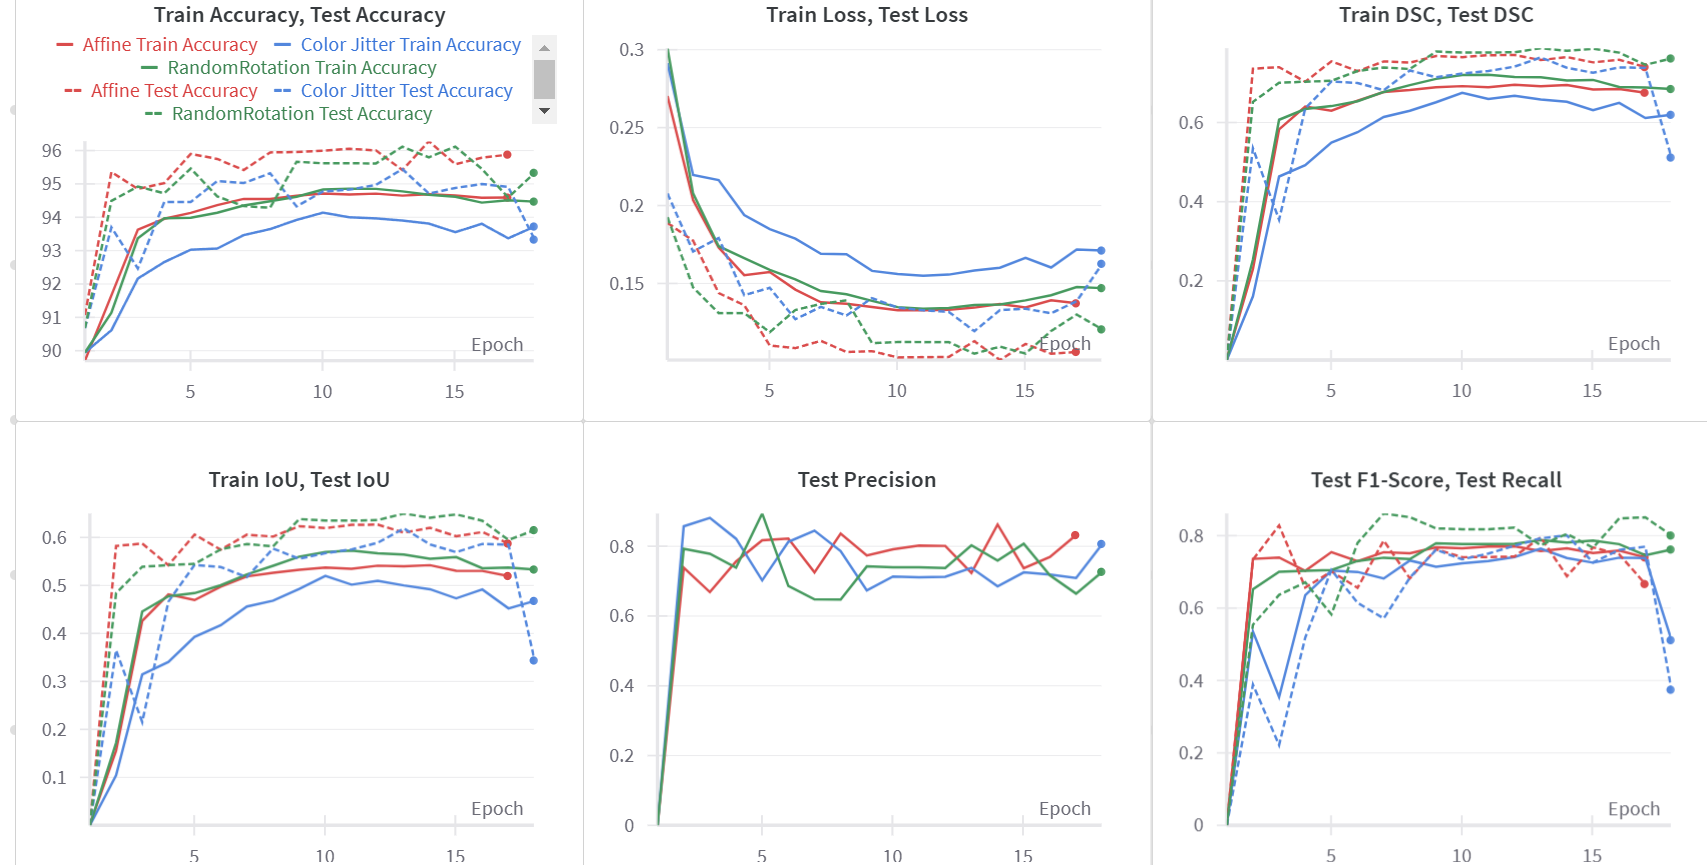



---


# **6. Making the prediction and experiment**

---



▶  **Function to display original, ground truth, and predicted masks**

Training with augmentation: RandomRotation
Epoch [1/10] for RandomRotation
Epoch [2/10] for RandomRotation
Epoch [3/10] for RandomRotation
Epoch [4/10] for RandomRotation
Epoch [5/10] for RandomRotation
Epoch [6/10] for RandomRotation
Epoch [7/10] for RandomRotation
Epoch [8/10] for RandomRotation
Epoch [9/10] for RandomRotation
Epoch [10/10] for RandomRotation
Training with augmentation: ColorJitter
Epoch [1/10] for ColorJitter
Epoch [2/10] for ColorJitter
Epoch [3/10] for ColorJitter
Epoch [4/10] for ColorJitter
Epoch [5/10] for ColorJitter
Epoch [6/10] for ColorJitter
Epoch [7/10] for ColorJitter
Epoch [8/10] for ColorJitter
Epoch [9/10] for ColorJitter
Epoch [10/10] for ColorJitter
Training with augmentation: Affine
Epoch [1/10] for Affine
Epoch [2/10] for Affine
Epoch [3/10] for Affine
Epoch [4/10] for Affine
Epoch [5/10] for Affine
Epoch [6/10] for Affine
Epoch [7/10] for Affine
Epoch [8/10] for Affine
Epoch [9/10] for Affine
Epoch [10/10] for Affine


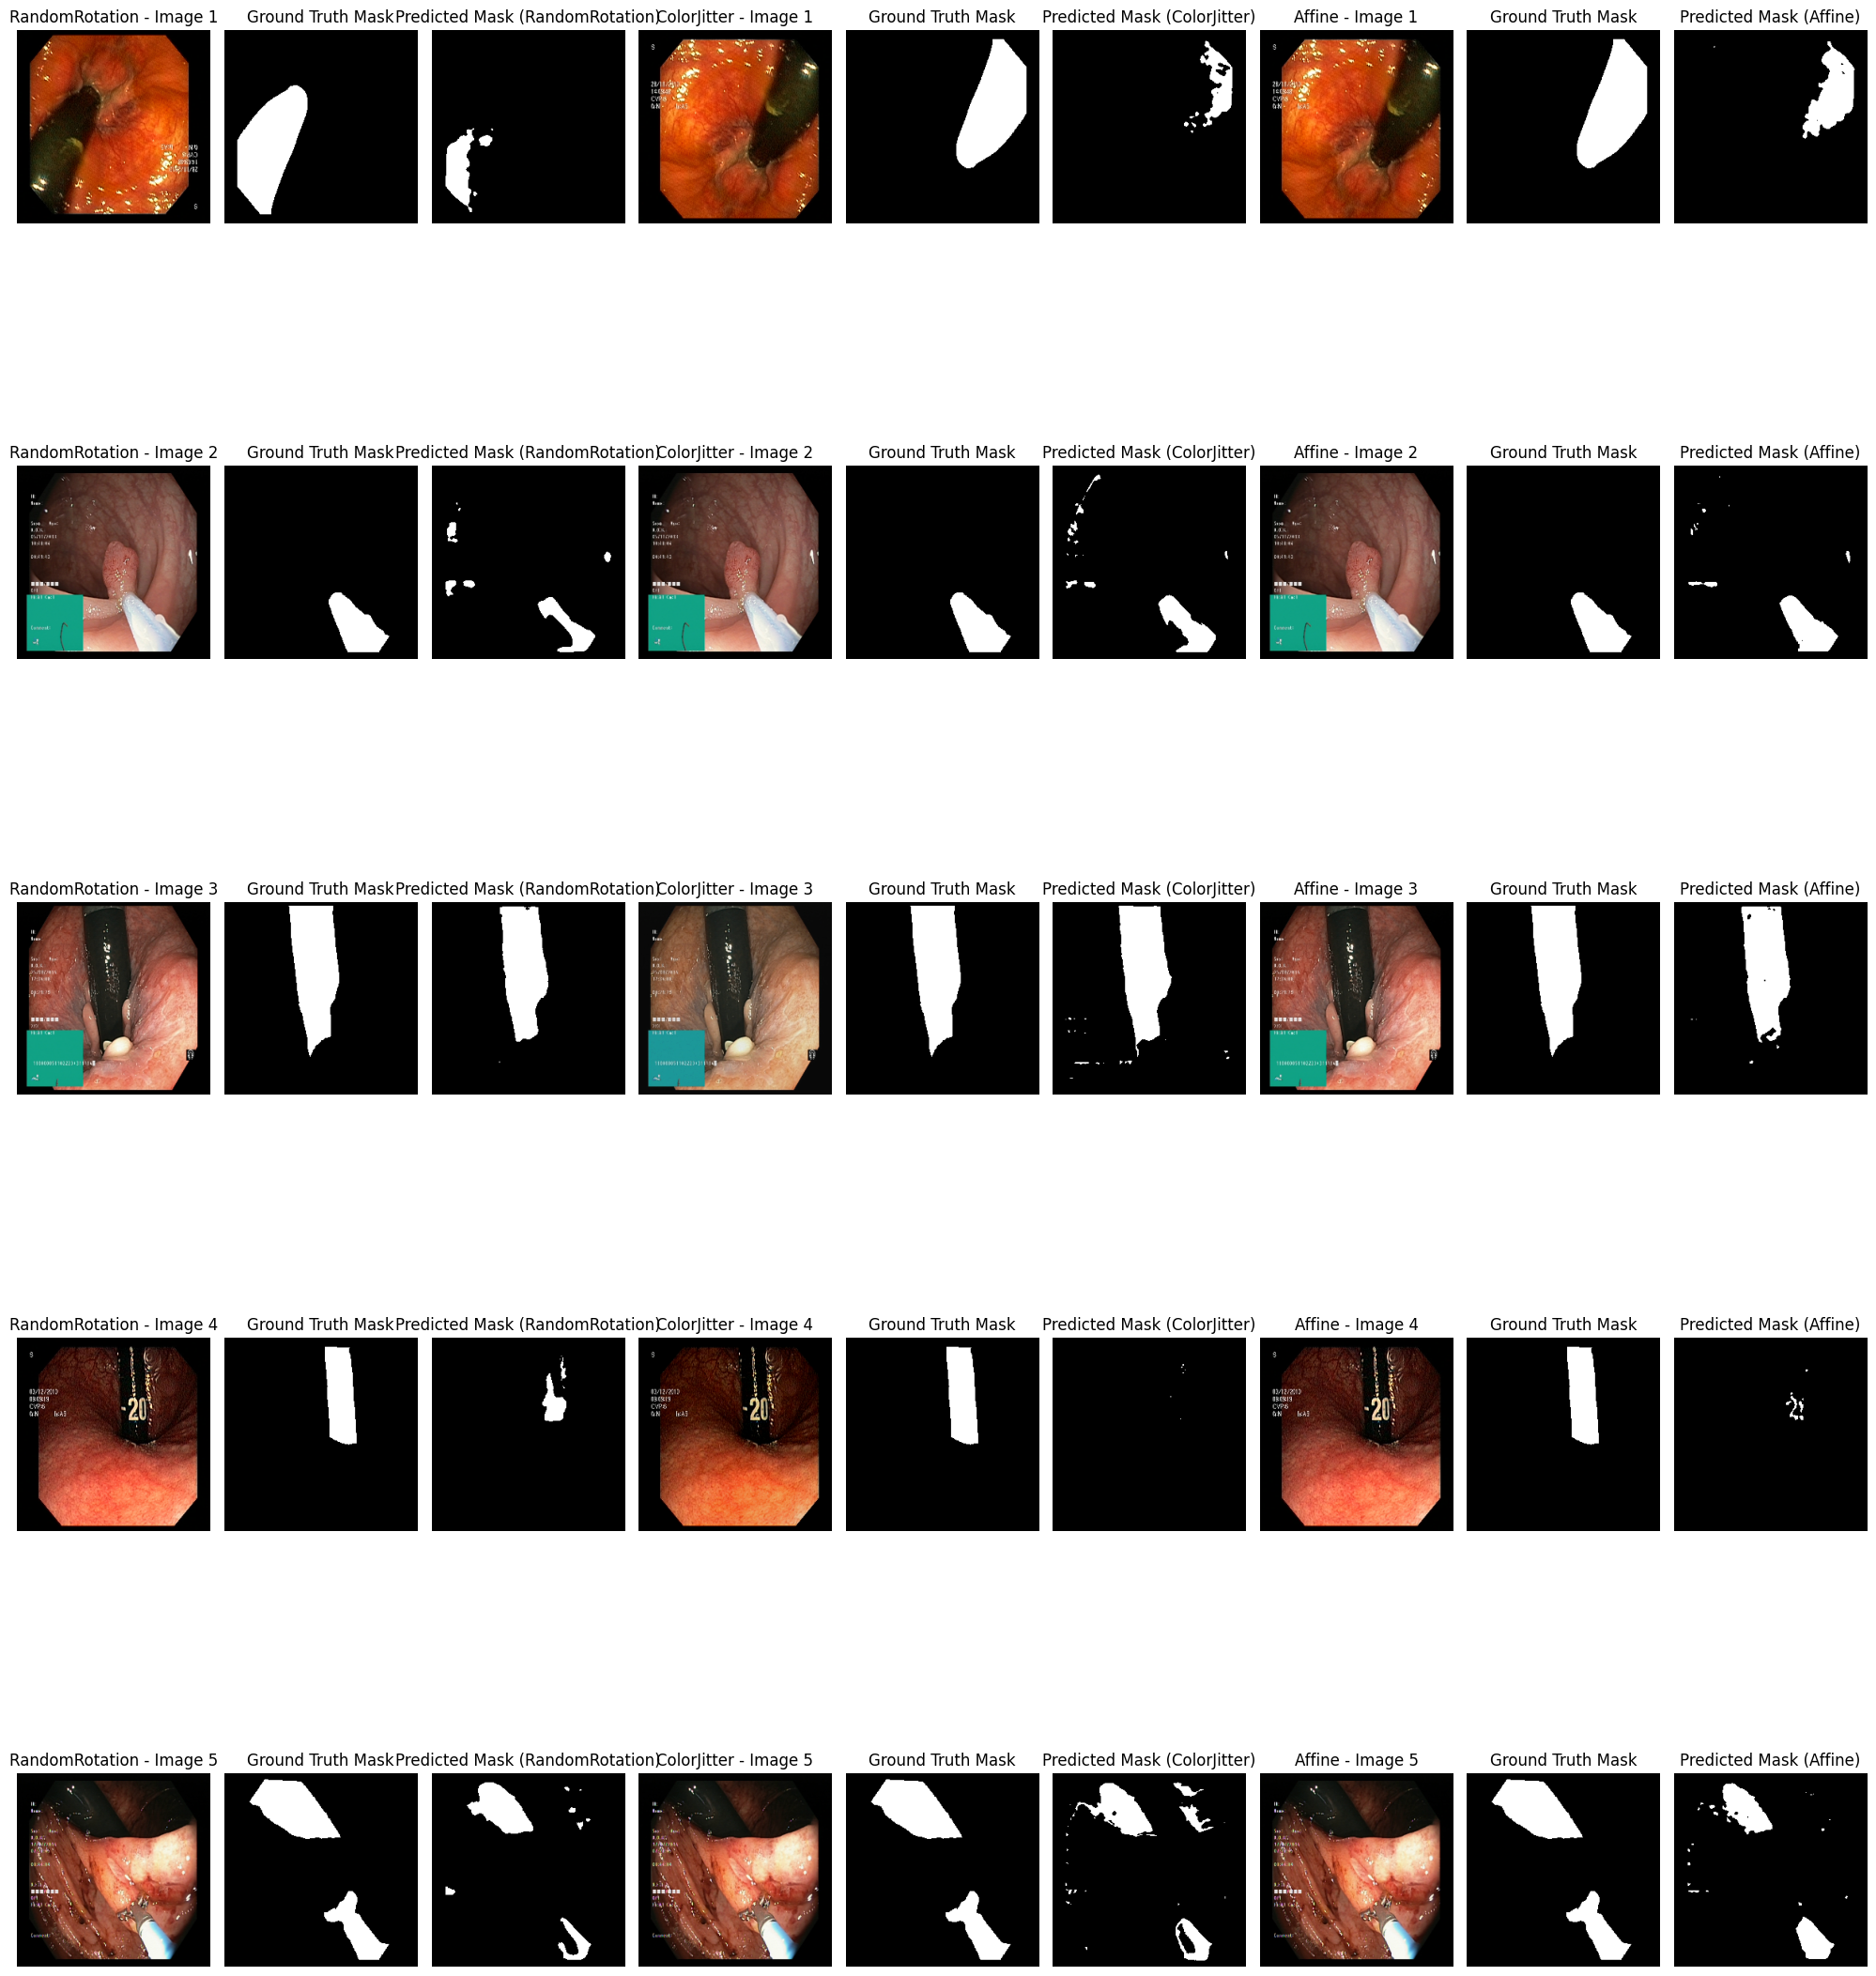

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

predictions_by_augmentation = {}

# Define a list of augmentations
augmentations = {
    "RandomRotation": A.Compose([A.Resize(256, 256), A.RandomRotate90(), A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)), ToTensorV2()]),
    "ColorJitter": A.Compose([A.Resize(256, 256), A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)), ToTensorV2()]),
    "Affine": A.Compose([A.Resize(256, 256), A.Affine(scale=(0.8, 1.2), translate_percent=(0.1, 0.1), rotate=(-30, 30), shear=(-10, 10)), A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)), ToTensorV2()])
}

for aug_name, aug_transform in augmentations.items():
    print(f"Training with augmentation: {aug_name}")

    train_dataset = KvasirDataset(train_files, images_dir, masks_dir, albumentations_transform=aug_transform)
    test_dataset = KvasirDataset(test_files, images_dir, masks_dir, albumentations_transform=aug_transform)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2, drop_last=False)

    model = UNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler_cosine = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)
    best_test_dsc = 0
    patience = 5
    epochs_no_improve = 0
    epochs_number = 10

    # Training loop
    for epoch in range(epochs_number):
        print(f"Epoch [{epoch + 1}/{epochs_number}] for {aug_name}")

        train_model(model, train_loader, criterion, optimizer, device)
        test_model(model, test_loader, criterion, device)

        # Early stopping
        if epochs_no_improve >= patience:
            print("Early stopping!")
            break

    collected_images, collected_masks, collected_pred_masks = [], [], []
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        with torch.no_grad():
            predicted_masks = (model(images) > 0.5).float()
        collected_images.extend(images.cpu())
        collected_masks.extend(masks.cpu())
        collected_pred_masks.extend(predicted_masks.cpu())
        if len(collected_images) >= 5:  # Limit to 5 images for comparison
            break

    predictions_by_augmentation[aug_name] = {
        "images": collected_images[:5],
        "true_masks": collected_masks[:5],
        "predicted_masks": collected_pred_masks[:5]
    }

# Function to display comparison of predictions
def display_comparison(predictions_by_augmentation):
    num_images = len(predictions_by_augmentation["RandomRotation"]["images"])
    num_augmentations = len(predictions_by_augmentation)

    plt.figure(figsize=(20, num_images * 5))
    for i in range(num_images):
        # Plot the original image
        for j, (aug_name, results) in enumerate(predictions_by_augmentation.items()):
            img = results["images"][i].numpy().transpose(1, 2, 0) * 0.5 + 0.5  # Unnormalize
            true_mask = results["true_masks"][i].squeeze().numpy()
            pred_mask = results["predicted_masks"][i].squeeze().numpy()

            # Display the image, true mask, and predicted mask for each augmentation
            plt.subplot(num_images, num_augmentations * 3, i * num_augmentations * 3 + j * 3 + 1)
            plt.imshow(img)
            plt.title(f"{aug_name} - Image {i + 1}")
            plt.axis("off")

            plt.subplot(num_images, num_augmentations * 3, i * num_augmentations * 3 + j * 3 + 2)
            plt.imshow(true_mask, cmap="gray")
            plt.title("Ground Truth Mask")
            plt.axis("off")

            plt.subplot(num_images, num_augmentations * 3, i * num_augmentations * 3 + j * 3 + 3)
            plt.imshow(pred_mask, cmap="gray")
            plt.title(f"Predicted Mask ({aug_name})")
            plt.axis("off")
    plt.tight_layout()
    plt.show()
display_comparison(predictions_by_augmentation)


▶  **Save the model**

In [ ]:
torch.save(model.state_dict(), 'model_experiment3_DataAugmentation.pth')